In [1]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

# Profit function

In [3]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [4]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Hjælpefunktion..

In [5]:
np.random.seed(123)

@jit(nopython=True)
def epsilon_greedy(Qtable, epsilon, uniform, state: int, price_grid: np.ndarray) -> int: 
    N = len(price_grid)
    assert Qtable.shape[0] == N, "Qtable must have the same number of rows as there are prices in the grid"
    assert Qtable.shape[1] == N, "Qtable must have the same number of columns as there are prices in the grid"
    assert state < N, "state must be a valid index in the price grid"
    assert state >= 0, "state must be a valid index in the price grid"

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
        #print("random")
    else:
        price_index = np.argmax(Qtable[:, state])
        #print("ikke random")
    return price_index

# Q-learning and simulation function

In [7]:
@jit(nopython=True)
def Qfunction(price_grid, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price_index_i = np.random.choice(len(price_grid)) 
    price_index_j = np.random.choice(len(price_grid)) 

    #state = np.random.choice(len(price_grid))

    Qtable_i = np.zeros((len(price_grid), len(price_grid)))
    Qtable_j = np.zeros((len(price_grid), len(price_grid)))

    profit_1 = np.zeros(int(period))
    profit_2 = np.zeros(int(period))

    total_profit = np.zeros(period)

    epsilons = (1 - theta)**np.arange(period + 1)
    uniforms = np.random.uniform(0, 1, (period + 1, 2))

    for t in range(1, period + 1):
        #epsilon = (1 - theta)**t

        # figure out who's turn it is
        if t % 2 == 0:
            # player 2 is the responder
            # set up pointers to the state and the Q table 
            state = price_index_j # the most recent draw of player 1's price
            Qtable_i = Qtable_j 
            Qtable_j = Qtable_i
            player_index = 1
            opponent_index = 0
        else:
            # player 1 is the responder
            state = price_index_j
            Qtable_i = Qtable_i
            Qtable_j = Qtable_j
            player_index = 0
            opponent_index = 1

        # draw i's action 
        # (actually, player i's action is already simulated by player j in the previous period)
        price_index_i = epsilon_greedy(Qtable_i, epsilons[t], uniforms[t, player_index], state=state, price_grid=price_grid)

        # current period
        decision = price_grid[price_index_i]
        state_i_responds_to = price_grid[state]
        profit_i_current_period = profit(decision, state_i_responds_to)

        # next period 
        state_next_period = price_index_i # next_period's state is today's price
        price_index_j_next_period = epsilon_greedy(Qtable_j, epsilons[t], uniforms[t, opponent_index], state=state_next_period, price_grid=price_grid)

        price_j_next_period = price_grid[price_index_j_next_period]
        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)

        max_Q = np.max(Qtable_i[:, price_index_j_next_period])
        continuation_value = max_Q 

        new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable_i[price_index_i, price_index_j]
        Qtable_i[price_index_i, price_index_j] = (1 - alpha) * prev_estimate + alpha * new_estimate

        # Update for the next iteration: Use the simulated next period's action as the actual action for the opponent
        if t % 2 == 0:
        # If current period is Player 2's turn, update Player 1's price for the next period
            price_index_j = price_index_i
            price_index_i = price_index_j_next_period
            profit_1[t-1] = profit(state_i_responds_to, decision)
            profit_2[t-1] = profit_i_current_period
        else:
        # If current period is Player 1's turn, update Player 2's price for the next period
            price_index_j = price_index_i
            price_index_i = price_index_j_next_period
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit(state_i_responds_to, decision)


        total_profit[t-1] = profit_i_current_period

    return total_profit, profit_1, profit_2


@jit(nopython=True)
def Simulations(sim, price, period, delta, alpha, theta):
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)

    for i in range(sim):
        total_profit_array, profit_1_array, profit_2_array = Qfunction(price, period, delta, alpha, theta)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:])
        avg_profit_2[i] = np.mean(profit_2_array[-1000:])
        avg_profit[i] = np.mean(total_profit_array[-1000:])

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim

In [26]:
np.random.seed(123)

@jit(nopython=True)
def Qfunction_test(price_grid, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price_index_i = np.random.choice(len(price_grid)) 
    price_index_j = np.random.choice(len(price_grid)) 

    Qtable_i = np.zeros((len(price_grid), len(price_grid)))
    Qtable_j = np.zeros((len(price_grid), len(price_grid)))
    Qtable_temp = np.zeros((len(price_grid), len(price_grid)))

    price_lists = np.zeros((int(period+1), int(2)))
    profit_1 = np.zeros(int(period))
    profit_2 = np.zeros(int(period))

    total_profit = np.zeros(period)

    epsilons = (1 - theta)**np.arange(period + 1)
    uniforms = np.random.uniform(0, 1, (period + 1, 2))

    #count=1

    for t in range(1, period + 1):
        #print("t=", t)
        # figure out who's turn it is
        if t % 2 == 0:
            # player 2 is the responder
            # set up pointers to the state and the Q table 
            state = price_index_j # the most recent draw of player 1's price
            #print("state er", state, "i periode", t)
            #Qtable_j = Qtable_i
            #print("Qtablei", Qtable_i, "i periode", t)
            #Qtable_i = Qtable_j
            #print("Qtablej", Qtable_j, "i periode", t)
            player_index = 1
            opponent_index = 0
        else:
            # player 1 is the responder
            state = price_index_j
            #print("state er", state, "i periode", t)
            #Qtable_i = Qtable_i
            #print("Qtablei", Qtable_i, "i periode", t)
            #Qtable_j = Qtable_j
            #print("Qtablej", Qtable_j, "i periode", t)
            player_index = 0
            opponent_index = 1

        # current period 
        decision = price_grid[price_index_i]
        #print("decision", decision)
        state_i_responds_to = price_grid[state]
        #print("state_i_responds_to", state_i_responds_to)
        profit_i_current_period = profit(decision, state_i_responds_to)
        #print("profit_i_current_period", profit_i_current_period)

        # next period 
        state_next_period = price_index_i # next_period's state is today's price
        #print("state_next_period", state_next_period)
        price_index_j_next_period = epsilon_greedy(Qtable_j, epsilons[t], uniforms[t, opponent_index], state=state_next_period, price_grid=price_grid)
        #print("price_index_j_next_period", price_index_j_next_period)

        price_j_next_period = price_grid[price_index_j_next_period]
        #print("price_j_next_period", price_j_next_period)
        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        #print("price_i_next_period", price_i_next_period)
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)
        #print("profit_i_next_period", profit_i_next_period)

        max_Q = np.max(Qtable_i[:, price_index_j_next_period])
        continuation_value = max_Q 

        new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable_i[price_index_i, state]
        #Qtable_i[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate
        #print("Opdaterede Qtablei", Qtable_i)

        # Profit
        total_profit[t-1] = profit_i_current_period
        #print("profit", total_profit)

         # Update for the next iteration: Use the simulated next period's action as the actual action for the opponent
        if t % 2 == 0:
        # If current period is Player 2's turn, update Player 1's price for the next period
            Qtable_i[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate
            #print("Opdaterede Qtablei ulige periode", Qtable_i)
            Qtable_temp = Qtable_j
            #print("Qtable_temp", Qtable_temp)
            Qtable_j = Qtable_i
            #print("Qtable_j", Qtable_j)
            Qtable_i = Qtable_temp
            #print("Qtable_i", Qtable_i)
            price_index_j = price_index_i
            price_index_i = price_index_j_next_period
            profit_1[t-1] = profit(state_i_responds_to, decision)
            profit_2[t-1] = profit_i_current_period
            #total_profit[count-1] = profit_i_current_period
            #total_profit[count] = profit(state_i_responds_to, decision)
            #total_profit[t-1] = profit_i_current_period
        else:
        # If current period is Player 1's turn, update Player 2's price for the next period
            Qtable_i[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate
            #print("Opdaterede Qtablei lige periode", Qtable_i)
            Qtable_temp = Qtable_j
            #print("Qtable_temp", Qtable_temp)
            Qtable_j = Qtable_i
            #print("Qtable_j", Qtable_j)
            Qtable_i = Qtable_temp
            #print("Qtable_i", Qtable_i)
            price_index_j = price_index_i
            price_index_i = price_index_j_next_period
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit(state_i_responds_to, decision)
            #total_profit[count-1] = profit_i_current_period
            #total_profit[count] = profit(state_i_responds_to, decision)
            #total_profit[t-1] = profit_i_current_period
        # Update pricelist
        #count = count + 2
        price_lists[t, player_index] = decision

    #print(total_profit)
    print(profit_1)
    print(profit_2)
    #total_profit = np.vastack(profit_1, profit_2)
    return price_lists, total_profit, profit_1, profit_2


@jit(nopython=True)
def Simulations_test(sim, price, period, delta, alpha, theta):
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)

    for i in range(sim):
        _, total_profit_array, profit_1_array, profit_2_array = Qfunction_test(price, period, delta, alpha, theta)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:])
        avg_profit_2[i] = np.mean(profit_2_array[-1000:])
        avg_profit[i] = np.mean(total_profit_array[-1000:])

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim

In [160]:
np.random.seed(123)
a, b, c, d  = Qfunction_test(P, 6, 0.95, 0.3, 0.0000276306)
#print("Qtable1 \n", e, "\n", "Qtable2 \n", f)
print(b[-1000:].mean())
print(c[-500:].mean())
print(d[-500:].mean())

res = np.concatenate((c[-500:], d[-500:]))
print(res.mean())


0.15277777777777776
0.05555555555555557
0.13194444444444442
0.09375


In [29]:
a, b, c, d = Qfunction_test(P, 50, 0.95, 0.3, 0.0000276306)

[0.         0.         0.13888889 0.13888889 0.         0.
 0.         0.22222222 0.         0.         0.11111111 0.
 0.         0.         0.         0.         0.         0.
 0.125      0.25       0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.13888889 0.13888889 0.         0.25       0.         0.
 0.         0.         0.13888889 0.13888889 0.25       0.25
 0.11111111 0.         0.         0.25       0.22222222 0.22222222
 0.22222222 0.11111111]
[0.         0.         0.         0.         0.         0.
 0.25       0.         0.         0.         0.11111111 0.22222222
 0.22222222 0.22222222 0.         0.         0.         0.
 0.125      0.         0.         0.         0.         0.
 0.         0.13888889 0.13888889 0.25       0.         0.
 0.         0.         0.22222222 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.13888889 0.13888889 0.         0.         0.
 0.         0.

# Time calculation for 1000 simulations

In [17]:
start_time  = time.time()

np.random.seed(128)
total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2 = Simulations_test(1000, P, 500000, 0.95, 0.3, 0.0000276306)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 43.49387979507446 seconds


In [105]:
#print("sidste periode:", total_profit_plot[:, -1])
#print(total_profit_plot[:, 1])
#print(np.mean(total_profit_plot, axis=0))
#print(avg_profit_1_plot)

#print(avg_profit_1_plot)
#print(total_profit_plot[:,-1])
test = total_profit_plot[:,-1]
res=0
for i in range(len(test)):
    res += test[i]

print(res/1000)
print(test)


#0.058

0.1255555555555567
[0.125      0.11111111 0.125      0.11111111 0.22222222 0.11111111
 0.11111111 0.125      0.11111111 0.13888889 0.11111111 0.11111111
 0.13888889 0.11111111 0.11111111 0.11111111 0.125      0.11111111
 0.         0.11111111 0.         0.125      0.11111111 0.22222222
 0.125      0.125      0.11111111 0.11111111 0.         0.22222222
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.125
 0.125      0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.125      0.11111111 0.22222222 0.11111111 0.11111111
 0.125      0.125      0.11111111 0.22222222 0.11111111 0.11111111
 0.125      0.11111111 0.125      0.11111111 0.125      0.11111111
 0.         0.11111111 0.125      0.125      0.11111111 0.125
 0.13888889 0.125      0.125      0.25       0.125      0.13888889
 0.11111111 0.125      0.         0.125      0.125      0.11111111
 0.25       0.         0.11111111 0.11111111 0.125      0.11111111
 0.125      0.11111111 0.25       0.125      0.111111

In [56]:
print(avg_profit_2_plot)

[0.125      0.11111111 0.125      0.11111111 0.05555556 0.11111111
 0.11111111 0.125      0.11111111 0.13194444 0.11111111 0.11111111
 0.13194444 0.11111111 0.11111111 0.11111111 0.125      0.11111111
 0.05555556 0.11111111 0.05555556 0.125      0.11111111 0.05555556
 0.125      0.125      0.11111111 0.11111111 0.05555556 0.05555556
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.125
 0.125      0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.125      0.11111111 0.05555556 0.11111111 0.11111111
 0.125      0.125      0.11111111 0.05555556 0.11111111 0.11111111
 0.125      0.11111111 0.125      0.11111111 0.125      0.11111111
 0.05555556 0.11111111 0.125      0.125      0.11111111 0.125
 0.125      0.125      0.125      0.13194444 0.125      0.13194444
 0.11111111 0.125      0.0625     0.125      0.125      0.11111111
 0.13194444 0.05555556 0.11111111 0.11111111 0.125      0.11111111
 0.125      0.11111111 0.13194444 0.125      0.11111111 0.08333333
 0.13

# Optimality - ikke færdig

In [8]:
def delta_prof(avg_array_1, avg_array_2, sim):
    together_array = np.vstack((avg_array_1, avg_array_2))
    #print(together_array)
    together_array_mean = np.mean(together_array, axis=0)
    delta_1 = np.zeros(len(together_array_mean))
    for i in range(sim):
        delta_1[i] = ((together_array_mean[i]) / (0.125))
    return delta_1

In [9]:
#dividing delta into intervals
def delta_div(delta_arr):
    new_delt = np.zeros(5)
    for i in range(len(delta_arr)):
        if delta_arr[i] <=1 and delta_arr[i] > 0.9: 
            new_delt[4]+=1
        elif delta_arr[i] <=0.9 and delta_arr[i] > 0.8:
            new_delt[3]+=1
        elif delta_arr[i] <=0.8 and delta_arr[i] > 0.7:
            new_delt[2]+=1
        elif delta_arr[i] <= 0.7 and delta_arr[i] > 0.6:
            new_delt[1]+=1
        else:
            new_delt[0] +=1
    return new_delt

In [10]:
delta_1 = delta_prof(avg_profit_1_plot, avg_profit_2_plot, 1000)

delta_2 = delta_div(delta_1)



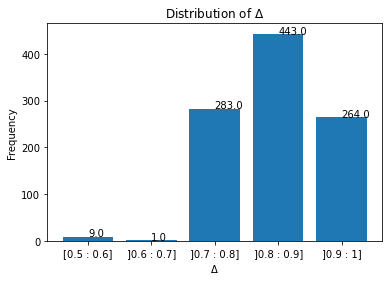

In [11]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

langs = ['[0.5 : 0.6]', ']0.6 : 0.7]', ']0.7 : 0.8]', ']0.8 : 0.9]', ']0.9 : 1]']

y_pos = np.arange(len(langs))

plt.title("Distribution of $\Delta$")
# Create bars
plt.bar(y_pos, delta_2)

addlabels(langs, delta_2 )
# Create names on the x-axis
plt.xticks(y_pos, langs)
plt.xlabel("$\Delta$")
plt.ylabel("Frequency")
#make label
label = [delta_2]
# Show graphic
plt.show()

# Profitability

In [24]:
#samlet_prof = total_profit_plot.mean(0)
samlet_prof = np.vstack((profit_total_1, profit_total_2)).mean(0)
#samlet_prof = test.mean()
#print(samlet_prof[-1])
#total_profit_plot.mean(0)
#print(total_profit_plot[-100:])
print(samlet_prof[-100:])
window_size = 1000
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array t o
#consider every window of size 1000
while i < len(samlet_prof) - window_size + 1:
  
    # Calculate the average of current window
    window_average = np.sum(samlet_prof[i:i+window_size]) / window_size
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

(1000, 500000)
(1000, 500000)
[0.10794444 0.109125   0.10913889 0.10811111 0.10773611 0.10883333
 0.10915278 0.10844444 0.10793056 0.10879167 0.10894444 0.10815278
 0.10794444 0.109125   0.10913889 0.10811111 0.10773611 0.10883333
 0.10915278 0.10844444 0.10793056 0.10879167 0.10894444 0.10815278
 0.10794444 0.109125   0.10913889 0.10811111 0.10773611 0.10883333
 0.10915278 0.10844444 0.10793056 0.10879167 0.10894444 0.10815278
 0.10794444 0.109125   0.10913889 0.10811111 0.10773611 0.10883333
 0.10915278 0.10844444 0.10793056 0.10879167 0.10894444 0.10815278
 0.10794444 0.109125   0.10913889 0.10811111 0.10773611 0.10883333
 0.10915278 0.10844444 0.10793056 0.10879167 0.10894444 0.10815278
 0.10794444 0.109125   0.10913889 0.10811111 0.10773611 0.10883333
 0.10915278 0.10844444 0.10793056 0.10879167 0.10894444 0.10815278
 0.10794444 0.109125   0.10913889 0.10811111 0.10773611 0.10883333
 0.10915278 0.10844444 0.10793056 0.10879167 0.10894444 0.10815278
 0.10794444 0.109125   0.1091388

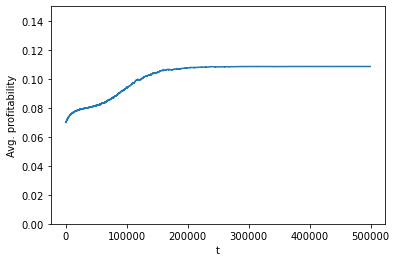

In [25]:
plt.plot(moving_averages, label="Average profitability")
plt.xlabel('t')
plt.ylabel('Avg. profitability')
plt.ylim(0.00, 0.15)
plt.show()